# Notebook for analysing all Stripe tracking / VR trials in one experiment folder

## (assumes use of FlyOver version 9.5 or higher)

In [24]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep
from sys import path, exit
from glob import glob
from scipy.interpolate import interp1d
from scipy import stats as sts
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

# import basic data processing function
from flyVR.utilities.loadSingleTrial import loadSingleVRLogfile

from trajectoryAnalysis.downsample import donwsampleFOData
from trajectoryAnalysis.trajectoryDerivedParams import convertRawHeadingAngle, velocityFromTrajectory, cartesian2polar
from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec, RayleighTest

from flyVR.flyVRstripetracking.flyVRstripetracking_oneTrialBasicAnalysis import processStripetrackingTrial

# import custom plotting functions
from plottingUtilities.basicPlotting import myAxisTheme, timeAxisTheme, makeNestedPlotDirectory, _myAccentList
from plottingUtilities.objectInteractionPlots import plotHeadingComparison, lineHistogram, plotWalkingVelocityDistr

import seaborn as sns 
sns.set_style('ticks')

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/'

root = Tk()
# prevents root window from appearing
root.withdraw()

# choose experiment folder
expDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)')
root.update()
root.destroy()
expDir = expDir + sep

analysisDir = sep.join(expDir.split(sep)[:-2]) + sep + 'analysis' + sep
try:
    mkdir(analysisDir)
except OSError:
    print('Analysis directory already exists.')
    
dataDir =  sep.join(expDir.split(sep)[:-2]) + sep

try:
    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/datafiles')
    exit(1)

print('\n Analysing the following files:\n')

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')

Analysis directory already exists.

 Analysing the following files:

Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [25]:
FODataFiles = FODataFiles[:]
FODataFiles

['Stripe_20deg_blackOnWhite_WTB_fly1_180628131352.txt',
 'Stripe_20deg_blackOnWhite_WTB_fly2_180628143838.txt',
 'Stripe_20deg_blackOnWhite_WTB_fly3_180628144623.txt',
 'Stripe_20deg_blackOnWhite_WTB_fly7_180628181300.txt',
 'Stripe_20deg_blackOnWhite_WTB_fly8_180628190548.txt']

### Compose mutli-fly data into dataframe

In [26]:
# generate fly color map

numFlies = len(FODataFiles[:])
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [27]:
keylist = ['gamma','gammaFull','headingAngle','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','moving']

keylistLong = ['flyID','trial','trialtype','sceneName'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [28]:
vTransTH = 2 #mm/s

# Run single trial analysis from each fly in folder .....................................................
for fileToAnalyse in FODataFiles:
    print('\n Analysing the following log files:\n')
    print(fileToAnalyse)
    
    dataFileParts = fileToAnalyse.split('_')
    genotype = dataFileParts[2]
    sceneName = dataFileParts[0] + dataFileParts[1]
    flyID = dataFileParts[4]#3
    titleString = 'fly '+flyID+' ('+genotype+')'+' in '+sceneName+' world'
    print(titleString)

    trial = 1

    if rerunbasicanalysis == 'y':
        #Load and process raw data
        processStripetrackingTrial(expDir, fileToAnalyse, dataDir, titleString)
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        print('Ran analysis, now loading saved *.npy file.')
    else:
        # just load existing npy file with processed data
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        print('Loading saved *.npy file.')

    trialtype = 'stripe'
    
    if ('inverted' in fileToAnalyse or 'Inverted' in fileToAnalyse):
        sceneName = 'inverted'+sceneName

    # add to data frame
    FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
    FODatLoad_df.insert(0, 'flyID', flyID)
    FODatLoad_df.insert(1, 'trial', trial)
    FODatLoad_df.insert(2, 'trialtype', trialtype)
    FODatLoad_df.insert(3, 'sceneName', sceneName)


    FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)



 Analysing the following log files:

Stripe_20deg_blackOnWhite_WTB_fly1_180628131352.txt
fly fly1 (blackOnWhite) in Stripe20deg world
Loading saved *.npy file.

 Analysing the following log files:

Stripe_20deg_blackOnWhite_WTB_fly2_180628143838.txt
fly fly2 (blackOnWhite) in Stripe20deg world
Loading saved *.npy file.

 Analysing the following log files:

Stripe_20deg_blackOnWhite_WTB_fly3_180628144623.txt
fly fly3 (blackOnWhite) in Stripe20deg world
Loading saved *.npy file.

 Analysing the following log files:

Stripe_20deg_blackOnWhite_WTB_fly7_180628181300.txt
fly fly7 (blackOnWhite) in Stripe20deg world
Loading saved *.npy file.

 Analysing the following log files:

Stripe_20deg_blackOnWhite_WTB_fly8_180628190548.txt
fly fly8 (blackOnWhite) in Stripe20deg world
Loading saved *.npy file.


In [29]:
%matplotlib inline 

In [30]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

In [31]:
FOAllFlies_df.head()

,flyID,trial,trialtype,sceneName,gamma,gammaFull,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,moving
0,fly1,1.0,stripe,Stripe20deg,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,0.0,NaN,0.0
1,fly1,1.0,stripe,Stripe20deg,0.0,0.0,0.0,0.0,0.050001,0.0,0.0,NaN,0.0,NaN,0.0
2,fly1,1.0,stripe,Stripe20deg,0.0,0.0,0.0,0.0,0.100002,0.0,0.0,NaN,0.0,NaN,0.0
3,fly1,1.0,stripe,Stripe20deg,0.0,0.0,0.0,0.0,0.150003,0.0,0.0,NaN,0.0,NaN,0.0
4,fly1,1.0,stripe,Stripe20deg,0.0,0.0,0.0,0.0,0.200004,0.0,0.0,NaN,0.0,NaN,0.0


In [32]:
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')

genotypeSex = fileToAnalyse.split('_')[1][:-2]

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Experimental conditions

In [33]:
sceneNames = list(set(FOAllFlies_df['sceneName'].values.tolist()))
sceneNames

['Stripe20deg']

In [34]:
genotypeSex = fileToAnalyse.split('_')[2]+fileToAnalyse.split('_')[3][0]
titleString = genotypeSex+', heading distribution with '+ sceneName

titleString

'blackOnWhiteW, heading distribution with Stripe20deg'

In [35]:
numFlies

5

In [36]:
flyIDs

['fly1', 'fly2', 'fly3', 'fly7', 'fly8']

#### Velocity distribution

In [37]:
try:
    mkdir(analysisDir + sep + 'walkingVelo' + sep)
except OSError:
    print('Analysis directory already exists.')
    
histRangeVT = (vTransTH, 30)
histRangeVR = (-5,5)
numBins = 30

Analysis directory already exists.


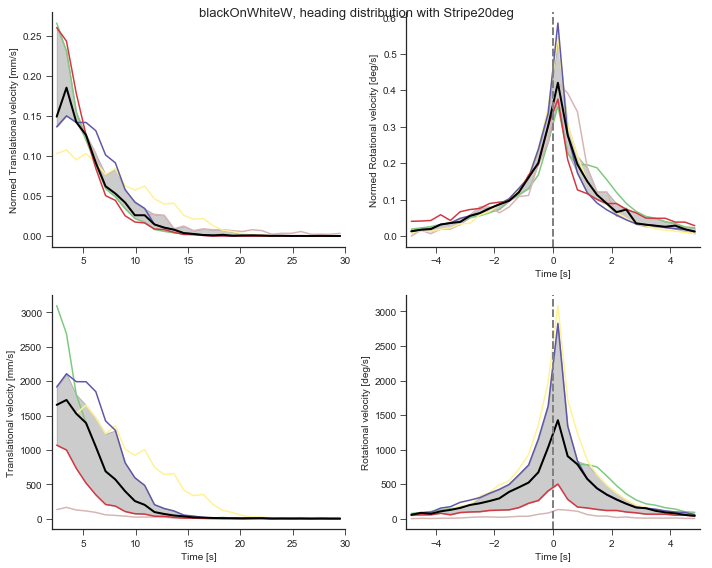

In [38]:
walkingFig = plotWalkingVelocityDistr(FOAllFlies_df, flyIDs, keyind_mov, keyind_vT, keyind_vR, flyCMap,
                             histRangeVT, histRangeVR,numBins, numFlies)
walkingFig.suptitle(titleString, fontsize=13)
walkingFig.tight_layout()

walkingFig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotypeSex + '_walingVelocities_'+sceneName+\
                   '_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

#### Heading angle distribution

In [39]:
try:
    mkdir(analysisDir + sep + 'heading' + sep)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


Stripe20deg

fly fly8 not moving
12.2388888889
fly fly8 not moving
12.2388888889


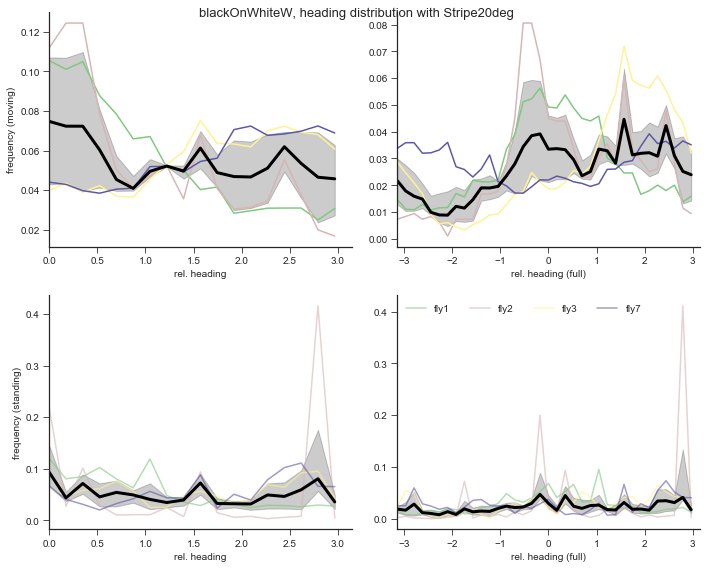

In [40]:
print(sceneName+'\n')
densityFlag = True
titleString = genotypeSex+', heading distribution with '+ sceneName

headingfig, nhead_fullGamma = plotHeadingComparison(FOAllFlies_df, flyIDs, sceneName, titleString,
                                                    keyind_gam, keyind_gamful, keyind_mov, flyCMap,
                                                    densityFlag, True)

headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+sceneName+\
                   '_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

np.savetxt(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+sceneName+\
                   '_n'+str(numFlies)+'.csv', nhead_fullGamma, delimiter=',')

Stripe20deg
fly fly8 not moving
12.2388888889
fly fly8 not moving
12.2388888889


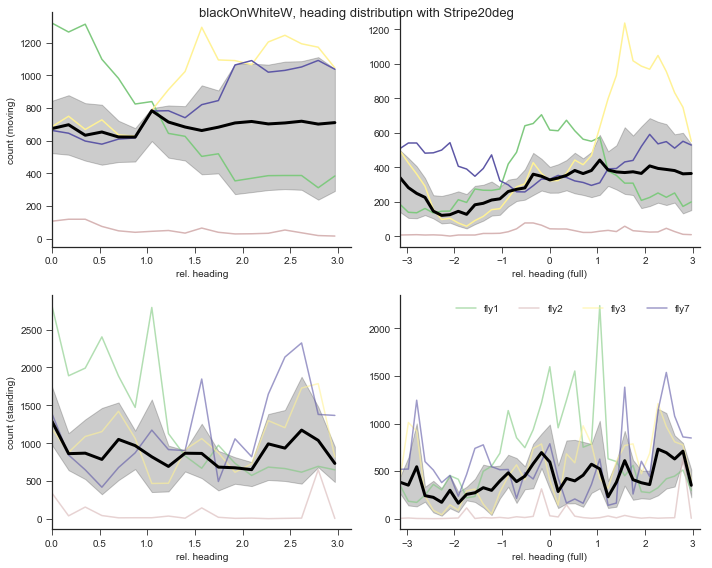

In [41]:
headingfig = plt.figure(figsize=(10,8))

print(sceneName)

densityFlag = False
titleString = genotypeSex+', heading distribution with '+ sceneName

headingfig, nhead_fullGamma = plotHeadingComparison(FOAllFlies_df, flyIDs, sceneName, titleString,
                                                    keyind_gam, keyind_gamful, keyind_mov, flyCMap,
                                                    densityFlag,True)

headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+sceneName+\
                   '_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

np.savetxt(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+sceneName+\
                   '_n'+str(numFlies)+'.csv', nhead_fullGamma, delimiter=',')

#### Relative heading frequency plot with color-coded mean translational velocity

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less_equal


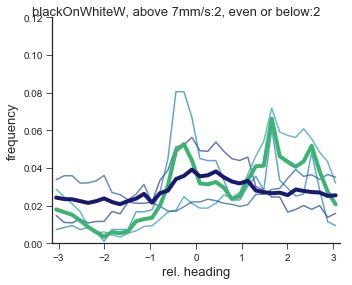

In [42]:
walkingHead, axs = plt.subplots(1, 1, figsize=(5,4))

cNorm  = colors.Normalize(vmin=3, vmax=15)
vtmap =  plt.cm.ScalarMappable(norm=cNorm,cmap='YlGnBu_r')

scene = 0
sceneName = sceneNames[scene]

binwidth = 10
nBins = 360/binwidth
angleLow = -np.pi
angleHigh = np.pi

vtTH = 7

meanvt = np.nan*np.ones(numFlies)
freqs = np.nan*np.ones((numFlies,nBins))

for fly in range(numFlies):
    querystring = '(flyID == "' + flyIDs[fly] + '" & sceneName == "'+sceneName+'")'

    flyMov = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()
    flyVT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze()
    flygamma = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()
    
    if(sum(flyMov)/len(flyMov)<0.2):
        continue
    
    #compute distribution
    bins = np.linspace(-np.pi, np.pi, nBins+1)
    [freq,edg] = np.histogram(flygamma[flyMov>0],bins)
    alphaBins = edg[:-1] + np.mean(np.diff(edg))/2

    meanvtFly = np.nanmean(flyVT[flyMov>0])
    meanvt[fly] = meanvtFly
    freqs[fly,:] = freq/(np.ones(len(freq))*np.sum(freq))

    axs.plot(alphaBins, freqs[fly], color=vtmap.to_rgba(meanvtFly),alpha=0.7)
    

axs.plot(alphaBins, np.mean(freqs[meanvt>vtTH,:], axis=0), color='mediumseagreen', linewidth=4)
axs.plot(alphaBins, np.mean(freqs[meanvt<=vtTH,:], axis=0), color='midnightblue', linewidth=4)

axs.set_ylabel('frequency', fontsize=13)
axs.set_xlabel('rel. heading', fontsize=13)
axs.set_ylim(0, 0.12)
axs.set_xlim(-np.pi, np.pi)
walkingHead.suptitle(genotypeSex+', above '+str(vtTH)+'mm/s:'+str(sum(meanvt>vtTH))+', even or below:'+str(sum(meanvt<=vtTH)), fontsize=13)
myAxisTheme(axs)

walkingHead.tight_layout()
walkingHead.savefig(analysisDir + 'heading'+sep+genotypeSex+'_walkingHead_n'+ str(numFlies)+'.pdf') 

## Compute circular statistics on heading distribution

In [131]:
angleLow = -np.pi
angleHigh = np.pi

headingPVA = np.nan*np.ones((numFlies,3))

from scipy.stats import circmean as circmean
import csv
import datetime

#print('Timestamp: {:%Y%m%d-%H%M%S}'.format(datetime.datetime.now()))
timestp = '{:%Y%m%d-%H%M%S}'.format(datetime.datetime.now())

fliesNotWalking = 0

for fly in range(len(flyIDs)):
    
    querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
    moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

    perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values

    if sum(moving)<=0.2*len(moving):
        print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))
        fliesNotWalking = fliesNotWalking+1

        continue
    gamFul = perFlyG[moving>0]
    meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

    headingPVA[fly,0] = meandir
    headingPVA[fly,1] = meanlen
    headingPVA[fly,2] = len(gamFul[~np.isnan(gamFul)])

try:
    mkdir(analysisDir + sep + 'circStats' + sep)
except OSError:
    print('Analysis directory already exists.')
    
np.savetxt(analysisDir + 'circStats/'  + genotypeSex + '_headingPVA_dir_'+sceneName+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotypeSex + '_headingPVA_len_'+sceneName+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,1], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotypeSex + '_headingPVA_n_'+sceneName+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,2], delimiter=',')

fly f02 not moving: 17.175
fly f05 not moving: 15.1416666667
Analysis directory already exists.


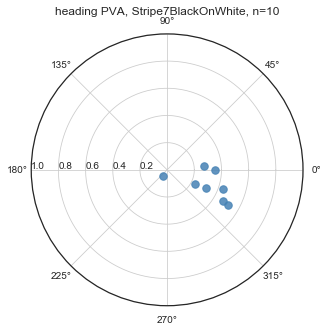

In [132]:
PVAFig = plt.figure(figsize=(5,5))

ax = PVAFig.add_subplot(111,projection='polar')
ax.plot(headingPVA[:,0],headingPVA[:,1],'.',markersize=15,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[:,0],headingPVA[:,1], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='black',alpha=1, markersize=10)
ax.set_rlim(0,1)
ax.set_rlabel_position(180)
ax.set_title('heading PVA, ' + sceneName + ', n='+str(numFlies))


PVAFig.savefig(analysisDir + 'circStats/'  + genotype
               + '_headingPVA_n'+ str(numFlies) +'.pdf', format='pdf') 

## Rayleigh test
This test is powerful at finding deviations from non-unimodal distributions. -> Significance of the mean angle.
This test should be performed on heading frequencies, where the frequency observed in each bin is considered a sample, i.e. n = number of bins.

In [133]:
binwidth = 10
nBins = 360/binwidth

fly = 2

querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values
perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values
gamFul = perFlyG[moving>0]

#compute distribution
bins = np.linspace(-np.pi, np.pi, nBins+1)
alphaBins = bins[:-1] + np.mean(np.diff(bins))
[freq,edg] = np.histogram(gamFul,bins, normed=True)

PVAdir, PVAlen = circmeanvec(alphaBins,freq, high=angleHigh, low=angleLow)

[z,p] = RayleighTest(PVAlen,len(freq))

## Fit von Mises distribution

In [134]:
#scipy.__version__

def vMFunc(x, mu, kappa):
    return np.exp(kappa * np.cos(x-mu)) / (2*np.pi*np.i0(kappa))

[ 0.12814436  0.20260204]


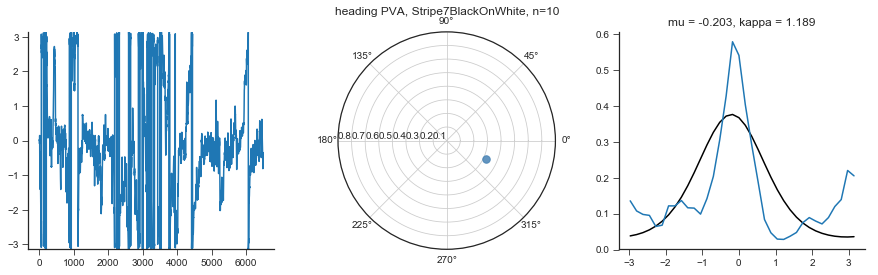

In [135]:
fly = 2
angleLow = -np.pi
angleHigh = np.pi

querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values

if sum(moving)<=0.2*len(moving):
    print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

gamFul = perFlyG[moving>0] #+ np.pi
meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

fitFig = plt.figure(figsize=(15,4))
ax = fitFig.add_subplot(131)
ax.plot(gamFul)
ax.set_ylim(angleLow, angleHigh)
myAxisTheme(ax)
ax2 = fitFig.add_subplot(132,projection='polar')
ax2.plot(meandir, meanlen,'.',markersize=15,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[:,0],headingPVA[:,1], high=angleHigh, low=angleLow)
ax2.set_rlim(0,0.8)
ax2.set_rlabel_position(180)
ax2.set_title('heading PVA, ' + sceneName + ', n='+str(numFlies))

bins = np.linspace(angleLow, angleHigh, 37)
x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(gamFul,bins, normed=True)

meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
perr = np.sqrt(np.diag(pcov))
print(perr)

mu = popt[0]
kappa = popt[1]
yhat = vMFunc(x,mu,kappa)

ax = fitFig.add_subplot(133)
ax.plot(x,yhat,'k')
ax.plot(x,n)
ax.set_title('mu = '+str(round(mu,3))+', kappa = '+str(round(kappa,3)))
myAxisTheme(ax)


fly f02 not moving: 17.175
fly f05 not moving: 15.1416666667


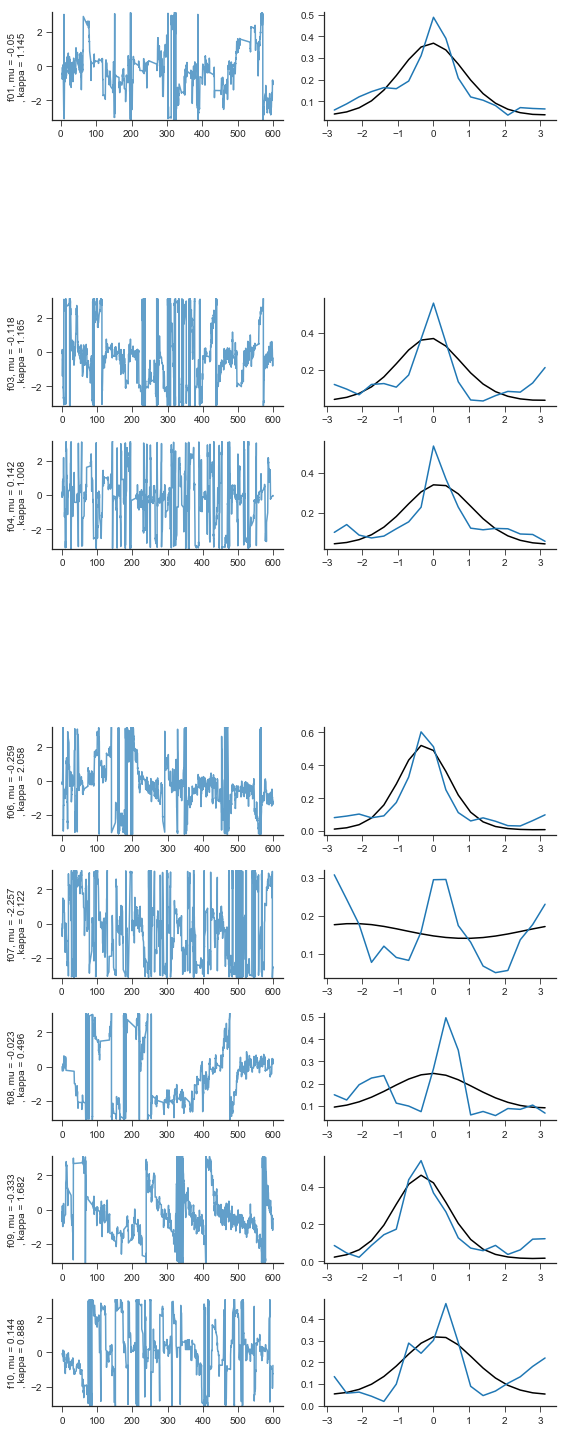

In [136]:
angleLow = -np.pi
angleHigh = np.pi

#bins size
binwidth = 20 #deg

numFlies = len(flyIDs)

vmfits = np.nan*np.ones((5,numFlies))
fitFig = plt.figure(figsize=(8,2*numFlies))

for fly in range(numFlies):
    querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
    moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

    perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values
    perFlyT = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

    if sum(moving)<=0.2*len(moving):
        print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))
        
        continue

    gamFul = perFlyG[moving>0]
    time = perFlyT[moving>0]
    
    bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
    x = bins[:-1] + np.mean(np.diff(bins))
    [n,edg] = np.histogram(gamFul,bins, normed=True)
    
    meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)
    
    popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
    mu = popt[0]
    kappa = popt[1]
    yhat = vMFunc(x,mu,kappa)

    #compute kolmogorov-smirnov statistic as measure of goodness of fit
    [ks, p] = sts.ks_2samp(n, yhat)
    
    #compute squared difference from fit
    sqd = np.sum(np.square(n-yhat))
    
    vmfits[0,fly] = mu
    vmfits[1,fly] = kappa
    vmfits[2,fly] = sqd
    vmfits[3,fly] = p
    vmfits[4,fly] = ks
    
    #plot fit results
    ax = fitFig.add_subplot(numFlies,2,1+fly*2)
    ax.plot(time,gamFul,alpha=0.7)
    ax.set_ylim(angleLow,angleHigh)
    ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))
    myAxisTheme(ax)

    ax = fitFig.add_subplot(numFlies,2,2+fly*2)
    ax.plot(x,yhat,'k')
    ax.plot(x,n)
    myAxisTheme(ax)

fitFig.tight_layout()

fitFig.savefig(analysisDir + 'circStats/'  + genotype
               + '_vMFit_n'+ str(numFlies) +'.pdf', format='pdf') 

flies with heading distribution that is significantly different from von Mieses fit (KS test):
['f06', 'f07', 'f08']
flies with large summed squared error:
['f03', 'f04', 'f06', 'f07', 'f08', 'f10']


/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less_equal
/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal


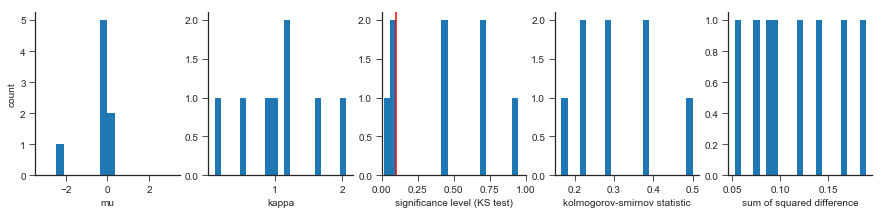

In [137]:
fitFig = plt.figure(figsize=(15,3))

bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

muax = fitFig.add_subplot(151)
muax.hist(vmfits[0,~np.isnan(vmfits[0,:])],bins)
#muax.set_xlim(-np.pi, np.pi)
muax.set_ylabel('count')
muax.set_xlabel('mu')
myAxisTheme(muax)

bins = np.linspace(0, 2, 21)
kapax = fitFig.add_subplot(152)
kapax.hist(vmfits[1,~np.isnan(vmfits[1,:])],len(bins))
#kapax.set_xlim(0, 2)
kapax.set_xlabel('kappa')
myAxisTheme(kapax)

bins = np.linspace(0, 1, 21)
pax = fitFig.add_subplot(153)
pax.hist(vmfits[3,~np.isnan(vmfits[3,:])],len(bins))
pax.set_xlim(0, 1)
pax.axvline(0.1,color='red')
pax.set_xlabel('significance level (KS test)')

bins = np.linspace(0, 1, 21)
ksax = fitFig.add_subplot(154)
ksax.hist(vmfits[4,~np.isnan(vmfits[4,:])],len(bins))
#ksax.set_xlim(0, 1)
ksax.set_xlabel('kolmogorov-smirnov statistic')
myAxisTheme(ksax)

bins = np.linspace(0, 1, 21)
ksax = fitFig.add_subplot(155)
ksax.hist(vmfits[2,~np.isnan(vmfits[2,:])],len(bins))
#ksax.set_xlim(0, 1)
ksax.set_xlabel('sum of squared difference')
myAxisTheme(ksax)

print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
print([flyIDs[fly] for fly in np.where(vmfits[3,:]<=0.1)[0]])

print('flies with large summed squared error:')
print([flyIDs[fly] for fly in np.where(vmfits[2,:]>=0.08)[0]])

myAxisTheme(pax)

fitFig.savefig(analysisDir + 'circStats/'  + genotype
               + '_vMFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


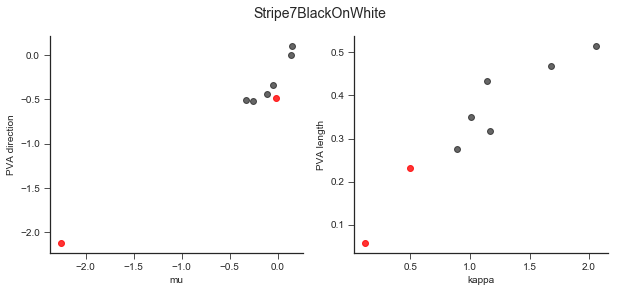

In [138]:
# Correlation between von Mieses fit and PVA
#Plot fit results
corrFig = plt.figure(figsize=(10,4))
corrFig.suptitle(sceneName,fontsize=14)

notFit = np.logical_and(vmfits[3,:]<=0.1, headingPVA[:,1]<0.5)

#correlation between mu and PVA direction
muax = corrFig.add_subplot(121)
muax.plot(vmfits[0,~notFit],headingPVA[~notFit,0],'ko',alpha=0.6)
muax.plot(vmfits[0,notFit],headingPVA[notFit,0],'ro',alpha=0.8)
muax.set_xlabel('mu'); muax.set_ylabel('PVA direction');
myAxisTheme(muax)

#correlation between kappa and PVA length
kapax = corrFig.add_subplot(122)
kapax.plot(vmfits[1,~notFit],headingPVA[~notFit,1],'ko',alpha=0.6)
kapax.plot(vmfits[1,notFit],headingPVA[notFit,1],'ro',alpha=0.8)
kapax.set_xlabel('kappa'); kapax.set_ylabel('PVA length');
myAxisTheme(kapax)

corrFig.savefig(analysisDir + 'circStats/'  + genotype
               + '_vM-vs-PVA_n'+ str(numFlies) +'.pdf', format='pdf') 

/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


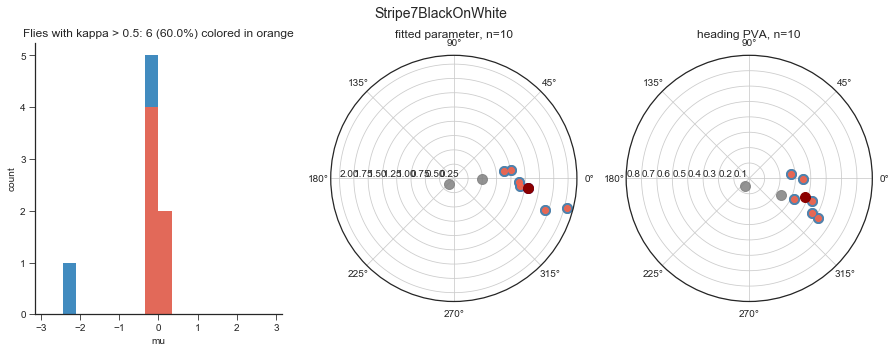

In [139]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5

goodFit = np.logical_and(~notFit,~np.isnan(headingPVA[:,1]))

slct = np.logical_and(vmfits[1,:]>kappaTH,goodFit)

bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(vmfits[0,~np.isnan(vmfits[0,:])],bins)
[n_slct,edg] = np.histogram(vmfits[0,slct],bins)
    
#Plot fit results
fixFig = plt.figure(figsize=(15,5))
fixFig.suptitle(sceneName,fontsize=14)

gs = gridspec.GridSpec(1,3,width_ratios=np.hstack((1,1.7,1.7)))

#histogram of fitted location (mu)
muax = fixFig.add_subplot(131)
muax.hist(vmfits[0,~np.isnan(vmfits[0,:])],bins,alpha=0.85)
muax.hist(vmfits[0,slct],bins,color='tomato',alpha=0.85)
muax.set_xlim(-np.pi, np.pi)
muax.set_xlabel('mu')
muax.set_ylabel('count')
muax.set_title('Flies with kappa > '+str(kappaTH)+': '+str(sum(vmfits[1,:]>kappaTH))+' ('+\
               str(round(100.0*sum(vmfits[1,:]>kappaTH)/float(numFlies),3))+'%) colored in orange')
myAxisTheme(muax)

#polar plot of fitted location and shape parameter
ax = fixFig.add_subplot(132,projection='polar')
ax.plot(vmfits[0,:],vmfits[1,:],'o',markersize=10,color='grey',alpha=0.85)
ax.plot(vmfits[0,goodFit],vmfits[1,goodFit],'o',markersize=10,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(vmfits[0,goodFit],vmfits[1,goodFit], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
ax.plot(vmfits[0,slct],vmfits[1,slct],'.',markersize=12,color='tomato',alpha=0.85)
meandir, meanlen = circmeanvec(vmfits[0,slct],vmfits[1,slct], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
#ax.set_rlim(0,1)
ax.set_rlabel_position(180)
ax.set_title('fitted parameter, n='+str(numFlies))

#polar plot of PVA
ax = fixFig.add_subplot(133,projection='polar')
ax.plot(headingPVA[:,0],headingPVA[:,1],'o',markersize=10,color='grey',alpha=0.85)
ax.plot(headingPVA[goodFit,0],headingPVA[goodFit,1],'o',markersize=10,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[:,0],headingPVA[:,1], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)

ax.plot(headingPVA[slct,0],headingPVA[slct,1],'.',markersize=12,color='tomato',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[slct,0],headingPVA[slct,1], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
ax.set_rlim(0,0.8)
ax.set_rlabel_position(180)
ax.set_title('heading PVA, n='+str(numFlies))

#fixFig.tight_layout()
fixFig.savefig(analysisDir + 'circStats/'  + genotype
               + '_vMFixation_n'+ str(numFlies) +'.pdf', format='pdf') 

### Use Rayleigh test on mean fixation location (on selected data)

In [140]:
# ...based on on fitted location parameter mu
fitSamples = len(vmfits[0,slct])
PVAdir, PVAlen = circmeanvec(vmfits[0,slct],np.ones(fitSamples), high=angleHigh, low=angleLow)

[z,p] = RayleighTest(PVAlen,fitSamples)

print('Test statistic z = ' + str(z))
print('Probability of test statistic p = ' + str(p))
if (p<0.001):
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.001).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
elif (p<0.01): 
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.01).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
elif (p<0.05): 
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.05).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
else:
    print('Accept H0 that sample is drawn from a uniform distribution (p>0.01).')

Test statistic z = 5.8045181916
Probability of test statistic p = 0.000525582466684
Reject H0 that sample is drawn from a uniform distribution (p<0.001).
Mean angle = -0.079 (-4.529 deg)


In [141]:
# ...based on PVA direction 
fitSamples = len(headingPVA[slct,0])
PVAdir, PVAlen = circmeanvec(headingPVA[slct,0],np.ones(fitSamples), high=angleHigh, low=angleLow)

[z,p] = RayleighTest(PVAlen,fitSamples)

print('Test statistic z = ' + str(z))
print('Probability of test statistic p = ' + str(p))
if (p<0.001):
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.001).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
elif (p<0.01): 
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.01).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
elif (p<0.05): 
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.05).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
else:
    print('Accept H0 that sample is drawn from a uniform distribution (p>0.01).')

Test statistic z = 5.64504379895
Probability of test statistic p = 0.000738828413904
Reject H0 that sample is drawn from a uniform distribution (p<0.001).
Mean angle = -0.286 (-16.362 deg)


### Selection of data

In [142]:
print('Total number of flies measured: ' + str(numFlies))
print('Number of flies that walked for less than 20% of trial time: ' + str(fliesNotWalking) \
      + ' out of '+str(numFlies))
print('Number of walking flies for which von Mises was good fit: ' + str(sum(goodFit))\
      + ' out of '+str(numFlies-fliesNotWalking))
print('Number of fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
      +str(sum(vmfits[1,:]>kappaTH)) + ' out of '+str(numFlies-fliesNotWalking))
print('Number of *well* fitted distributions with concentration measure kappa > '+str(kappaTH)+' (orange marked dots): '\
      +str(sum(vmfits[1,goodFit]>kappaTH)) + ' out of '+str(sum(goodFit)))

Total number of flies measured: 10
Number of flies that walked for less than 20% of trial time: 2 out of 10
Number of walking flies for which von Mises was good fit: 6 out of 8
Number of fitted distributions with concentration measure kappa > 0.5: 6 out of 8
Number of *well* fitted distributions with concentration measure kappa > 0.5 (orange marked dots): 6 out of 6


/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


### Visualise performance with bar plot

/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


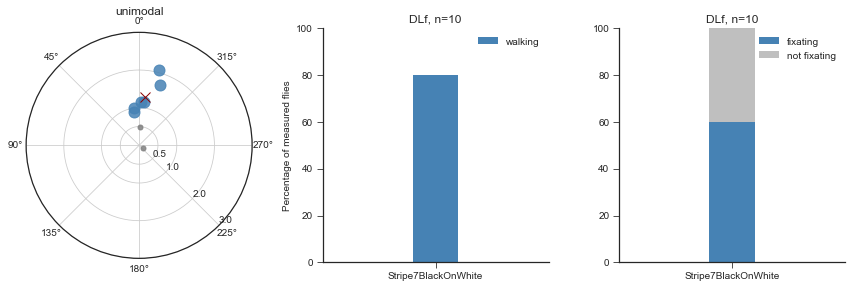

In [143]:
fixBarFig  = plt.figure(figsize=(12,4), )
width = 0.2
ind = 0
scene = sceneNames[ind]

walking = 100.0*(numFlies-fliesNotWalking)/numFlies
fixating = 100.0*sum(vmfits[1,goodFit]>kappaTH)/(numFlies-fliesNotWalking)

goodFit = np.logical_and(~notFit,~np.isnan(headingPVA[:,1]))
slct = np.logical_and(vmfits[1,:]>kappaTH,goodFit)
gfplt = np.logical_and(goodFit, ~slct)

#polar plot of fitted location and shape parameter - unimodal
ax = fixBarFig.add_subplot(131,projection='polar')
ax.plot(vmfits[0,~goodFit],vmfits[1,~goodFit],'.',markersize=10,color='grey',alpha=0.85)
ax.plot(vmfits[0,gfplt],vmfits[1,gfplt],'o',markeredgecolor='steelblue',
        markerfacecolor='none',  markeredgewidth=1.2, markersize = 9,alpha=0.85)
ax.plot(vmfits[0,slct],vmfits[1,slct],'o',markersize=11,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(vmfits[0,slct],vmfits[1,slct], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'x', color='darkred',alpha=1, markersize=10)

ax.set_title('unimodal')
ax.set_rlabel_position(225)
ax.set_yticks([0.5, 1, 2, 3])
ax.set_ylim(0, 3)
ax.set_theta_zero_location("N")

#plot bar graph of percentage of flies that walk and fixate
ax = fixBarFig.add_subplot(132)
p1 = ax.bar(ind+1, walking, width, color='steelblue')
ax.set_ylabel('Percentage of measured flies')
ax.legend([p1], ['walking'])
ax.set_xlim(0.5, 1.5); ax.set_ylim(0, 100)
ax.set_title(genotypeSex + ', n=' + str(numFlies) )
plt.sca(ax)
plt.xticks([1], [scene], rotation=0)
myAxisTheme(ax)

ax = fixBarFig.add_subplot(133)
fixating = 100.0*sum(vmfits[1,goodFit]>kappaTH)/numFlies
p1 = ax.bar(ind+1, fixating, width, color='steelblue')
p2 = ax.bar(ind+1, 100.0 - fixating, width, bottom=fixating, color='grey', alpha=0.5)
#plt.xticks(ind, scene)
ax.legend([p1, p2], ['fixating', 'not fixating'])
ax.set_xlim(0.5, 1.5); ax.set_ylim(0, 100)
ax.set_title(genotypeSex + ', n=' + str(numFlies) )
plt.sca(ax)
plt.xticks([1], [scene], rotation=0)
myAxisTheme(ax)
    
fixBarFig.tight_layout()

fixBarFig.savefig(analysisDir + 'circStats/'  + genotype +
                   '_fixationBarPlot_n'+ str(numFlies) +'.pdf', format='pdf') 

### Relationship between walking velocity and fixation

/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


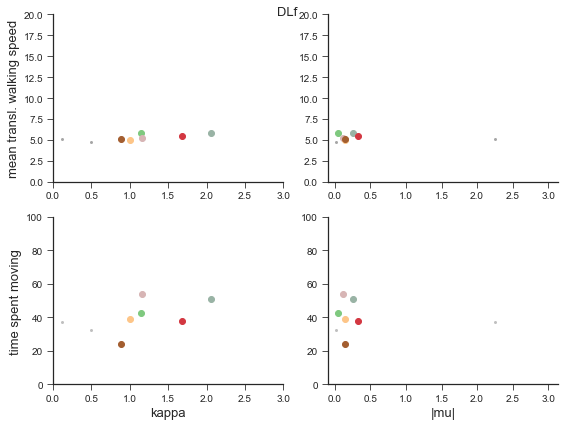

In [144]:
walkingCorr, axs = plt.subplots(2, 2, figsize=(8,6))

scene = 0
sceneName = sceneNames[scene]
    
goodFit = np.logical_and(np.logical_or(vmfits[3,:]>0.1, headingPVA[:,1]>0.5),\
                              ~np.isnan(headingPVA[:,1]))
kappasFly = vmfits[1,:]
absmuFly = abs(vmfits[0,:])
slct = np.logical_and(vmfits[1,:]>kappaTH,goodFit)

for fly in range(numFlies):
    querystring = '(flyID == "' + flyIDs[fly] + '" & sceneName == "'+sceneName+'")'

    flyMov = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()
    flyVT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze()

    if slct[fly]:
        axs[0,0].plot(kappasFly[fly], np.nanmean(flyVT[flyMov>0]), 'o', color=flyCMap.to_rgba(fly))
        axs[0,1].plot(absmuFly[fly], np.nanmean(flyVT[flyMov>0]), 'o', color=flyCMap.to_rgba(fly))
    else:
        axs[0,0].plot(kappasFly[fly], np.nanmean(flyVT[flyMov>0]), '.', markerfacecolor='grey', markeredgecolor='none', alpha=.7)
        axs[0,1].plot(absmuFly[fly], np.nanmean(flyVT[flyMov>0]), '.', markerfacecolor='grey', markeredgecolor='none', alpha=.7)

    if slct[fly]:
        axs[1,0].plot(kappasFly[fly], 100.*np.sum(flyMov)/len(flyMov), 'o', color=flyCMap.to_rgba(fly))
        axs[1,1].plot(absmuFly[fly], 100.*np.sum(flyMov)/len(flyMov), 'o', color=flyCMap.to_rgba(fly))
    else:
        axs[1,0].plot(kappasFly[fly], 100.*np.sum(flyMov)/len(flyMov), '.', markerfacecolor='grey', markeredgecolor='none', alpha=.5) 
        axs[1,1].plot(absmuFly[fly], 100.*np.sum(flyMov)/len(flyMov), '.', markerfacecolor='grey', markeredgecolor='none', alpha=.5) 

axs[0,0].set_ylabel('mean transl. walking speed', fontsize=13)
axs[1,0].set_xlabel('kappa', fontsize=13)
axs[1,1].set_xlabel('|mu|', fontsize=13)
axs[1,0].set_ylabel('time spent moving', fontsize=13)
for i in range(2):
    axs[0,i].set_ylim(0, 20)
    axs[1,i].set_ylim(0, 100)
    axs[i,0].set_xlim(0, 3)
    axs[i,1].set_xlim(-0.1, np.pi)
walkingCorr.suptitle(genotypeSex, fontsize=13)
#[axs[i].set_xlim(0, 5) for i in range(2)]
[[myAxisTheme(axs[i,j]) for i in range(2)] for j in range(2)]

walkingCorr.tight_layout()
walkingCorr.savefig(analysisDir + 'velocityTraces'+sep+genotypeSex+'_walkingCorr_n'+ str(numFlies)+'.pdf') 